In [1]:
import random
import copy
import numpy as np
import theano as T
import theano.tensor as tt
import pymc3 as pm
import pandas as pd
import rpy2
from rpy2.robjects import pandas2ri
pandas2ri.activate()
%load_ext rpy2.ipython


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
%%capture  --no-stderr --no-stdout --no-display
%%R

library(ggplot2)
library(reshape)
library(grid)
library(dplyr)
library(gridExtra)
library(lme4)

paper_theme_2 <- theme_light() + theme(
                                       legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.y=element_text(size=16),

                            axis.text.x=element_text(size=16),
                         axis.title.x=element_text(face="plain"),
                            axis.title.y=element_text(face="plain"))
# title =element_text(size=16, face='bold'))

paper_theme_3 <- theme( axis.title.x = element_text(size=18),
  axis.text.x=element_text(colour="black", 
                           size = 14), 
  axis.title.y = element_text(size = 18, vjust = 1),
  axis.text.y  = element_text(size = 14),
  strip.text=element_text(size=16),
  axis.line.x = element_line(colour = "black"), 
  axis.line.y = element_line(colour = "black"),
  legend.title=element_text(size=18),
  legend.text=element_text(size=16))  

  

/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following object is masked from ‘package:reshape’:

    rename


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘gridExtra’


  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.5/dist-packages/rpy2/rinterface/__init__.py:145:

In [3]:
%%R --o data_resp

#data_resp_loc <- read.csv("data/estimation_dot_gaze.csv", sep="\t")
data_resp_loc <- read.csv('r_data/r_resp_250.csv')
data_tracker <- read.csv("data/estimation_tracker_data.csv", sep="\t")


data_tracker$trial_id <- data_tracker$trial_id - 1
data_resp_loc$trial_id <- data_resp_loc$trial_id - 1


data_resp_loc <- data_resp_loc %>%
                filter(belowX >=0) 
                #mutate(belowX=max(0.1,belowX))

trials <- (unique(data_resp_loc$trial_id))

data_tracker <- data_tracker %>%
                group_by(trial_id) %>%
                filter(trial_id %in% trials)


data_resp_loc$id <- seq.int(1, nrow(data_resp_loc))


data_resp <- data_resp_loc %>%
     #mutate(Dots_Counted=max(min(5*Dots_Shown, Dots_Counted),0.1*Dots_Shown)) %>%

      filter(gazeDist > 0 & Dots_Shown < 150 & Dots_Shown >= 10) %>%
      #mutate(gazeDist=max(0,gazeDist)) %>%

      mutate(err=Dots_Counted - Dots_Shown) %>%
      mutate(abs_err = abs(err)) %>%
      mutate(within_x = 2/(1 + exp(-0.6 -0.2*belowX)) - 1) %>%
      group_by(trial_id) %>% 
      mutate(belowX = mean(belowX)) %>%
      mutate(within_x = mean(within_x)) %>%
      mutate(nLooks=mean(nLooks)) %>%
      #mutate(within_x=mean(pInGaze**0.2)) %>%

      mutate(within_x_tot = sum(within_x)) %>%
      mutate(nLooks = mean(nLooks)) %>%
      mutate(pathLength = mean(pathLength)) %>%
      mutate(medFix = mean(medFix)) %>%
      mutate(mean_dist=sum(gazeDist)/Dots_Shown) %>%
      mutate(mean_abs_err = mean(abs_err)) %>%
      mutate(pct_err=err/Dots_Shown) %>%
        mutate(abs_pct_err=abs_err/Dots_Shown) %>%

      top_n(n=1, wt=id)  %>%
      filter(abs_pct_err <= 1.) %>%
      group_by(Subject, pid)%>%
      filter(length(Subject) > 0) 


data_tracker <- data_tracker %>%
                  filter(ValidityLeft == 0 & ValidityRight == 0) %>%

                mutate(av_x = (GazePointXLeft +GazePointXRight)/2) %>%
                mutate(av_y = (GazePointYLeft +GazePointYRight)/2) %>%
                group_by(trial_id) %>%
                mutate(Time = round(max(TimeStamp)/100)/10)

data_tracker$id <- seq.int(1,nrow(data_tracker))
data_resp$Time <- as.factor(round(data_resp$Time,2))



In [4]:
data_resp = pandas2ri.ri2py(data_resp)

In [5]:
def remove_n(ls,n):
    ret = []
    for l in ls:
        l_rem = l[:n]
        ret.append(l_rem)
    return ret


subj_group = data_resp.groupby(["pid", "Subject"])
#subj_group = data_resp.groupby(["pid", "Subject", "Time"])
#subj_group = data_resp.groupby(["Time"])

dots_shown,dots_counted,pct_area,seen,n_look,times,pid=[],[],[],[],[],[],[]
for i,subj in subj_group:
    times.append([float(i) for i in list(subj["Time"])])
    dots_shown.append(list(subj["Dots_Shown"]))
    dots_counted.append(list(subj["Dots_Counted"]))
    pct_area.append(list(subj["pctArea"] * 0.95))
    seen.append(list(subj["within_x_tot"]))
    n_look.append(list(subj["nLooks"]))
    pid.append(list(subj["Subject"]))

ns = [len(n) for n in seen]
min_n = min(ns)



dots_shown = remove_n(dots_shown, min_n)
pid = remove_n(pid, min_n)
dots_counted = remove_n(dots_counted, min_n)
pct_area = remove_n(pct_area, min_n)
seen = remove_n(seen, min_n)
n_look = remove_n(n_look, min_n)
times = remove_n(times, min_n)


dots_shown=np.array(dots_shown)
dots_counted=np.array(dots_counted)
pct_area=np.array(pct_area)
seen=np.array(seen)
n_look = np.array(n_look)
times = np.array(times)
unseen = dots_shown - seen
pid=np.array(pid)



with pm.Model() as mod:
    
    beta_group_mean = pm.Normal("beta_grp_mu", mu=0, sd=5,testval=0)
    weber_group_mean = pm.Normal("weber_grp_mu", mu=-0.1, sd=0.01,testval=0)

    weber_time_group_mean = pm.Normal("weber_time_grp_mu",mu=0, sd=5,testval=0)
    beta_time_group_mean = pm.Normal("beta_time_grp_mu",mu=0, sd=5,testval=0)
    
    
    beta_group_sd = pm.HalfNormal("beta_grp_sd",sd=5,testval=1)
    weber_group_sd = pm.HalfNormal("weber_grp_sd",sd=5,testval=1)

    weber_time_group_sd = pm.HalfNormal("weber_time_grp_sd", sd=5,testval=1)
    beta_time_group_sd = pm.HalfNormal("beta_time_grp_sd",sd=5,testval=1)

    beta = pm.Normal("slope", mu=beta_group_mean, 
                             sd=beta_time_group_sd, shape=(len(dots_shown), 1))
    weber = pm.Normal("weber", mu=weber_group_mean,
                          sd=weber_group_sd, shape=(len(dots_shown), 1))
    time_weber = pm.Normal("time_weber",mu=weber_time_group_mean,
                           sd=weber_time_group_sd, shape=(len(dots_shown), 1), testval=0.)
    time_slope = pm.Normal("time_slope",mu=beta_time_group_mean,
                           sd=beta_time_group_sd, shape=(len(dots_shown), 1), testval=0.)
    

    #dev_unseen = pm.HalfNormal("dev_unseen", sd=5, shape=(len(dots_shown), 1))
    #weber = (weber + abs(weber))/2. + 1e-8 #this removes negatives
   # s = tt.exp(beta + time_slope * tt.log(times))
   # w = tt.exp(weber + time_weber*tt.log(times))
    s = tt.exp(beta + time_slope * tt.log(times))
    w = tt.exp(weber + time_weber*tt.log(times))

    
    guess = s  * dots_shown
    guess_sd = w * guess 
    
    #guess_sd += dev_unseen * 
    
    lkhd = pm.Normal("lkhd", mu=guess, sd=guess_sd, observed=dots_counted)
    trace = pm.sample(400, tune=250, cores=2, njobs=2, chains=2)
    

    
    
    

summary = pm.summary(trace)
print(summary)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.5/dist-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [time_slope, time_weber, weber, slope, beta_time_grp_sd_log__, weber_time_grp_sd_log__, weber_grp_sd_log__, beta_grp_sd_log__, beta_time_grp_mu, weber_time_grp_mu, weber_grp_mu, beta_grp_mu]
100%|██████████| 650/650 [00:21<00:00, 29.96it/s]
Only 400 samples in chain.
The acceptance probability does not match the target. It is 0.9728359923337525, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Only 400 samples in chain.
The acceptance probability does not match the target. It is 0.922

                       mean        sd  mc_error   hpd_2.5  hpd_97.5  n_eff  \
beta_grp_mu       -0.251546  0.030277  0.001134 -0.312963 -0.194330  800.0   
weber_grp_mu      -0.102182  0.010142  0.000329 -0.122978 -0.083779  800.0   
weber_time_grp_mu -0.023773  0.018132  0.001035 -0.064997  0.007917  241.0   
beta_time_grp_mu   0.051305  0.030478  0.001037 -0.002781  0.115702  780.0   
slope__0_0        -0.280641  0.032182  0.001408 -0.346559 -0.224245  352.0   
slope__1_0        -0.444968  0.027546  0.000858 -0.502875 -0.396668  800.0   
slope__2_0        -0.135570  0.036071  0.001420 -0.202407 -0.060606  589.0   
slope__3_0        -0.170253  0.040165  0.001470 -0.246321 -0.090316  510.0   
slope__4_0        -0.152442  0.029117  0.001031 -0.207470 -0.094280  623.0   
slope__5_0        -0.115511  0.033470  0.001085 -0.175169 -0.045812  800.0   
slope__6_0        -0.245337  0.038084  0.001435 -0.315028 -0.170063  624.0   
slope__7_0        -0.162843  0.031247  0.000994 -0.227224 -0.104

In [6]:
summary_mean = summary["mean"]
summary_sd = summary["sd"]
summary_low = summary["hpd_2.5"]
summary_high = summary["hpd_97.5"]

vals = {}
rownames = list(summary.index)

n_groups = seen.shape[0]
n_per_group = seen.shape[1]

print(summary_mean)
print(summary_sd)


vals = {}
for i in range(len(rownames)):
    rowname = rownames[i]
    rowname = rowname[:rowname.find("__")]
    
    if 'grp' in rowname:
        vals[rowname] = [summary_mean[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_low"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]
        vals[rowname+"_high"] = [summary_sd[i] for _ in range(n_per_group*n_groups)]

    else:
        if rowname not in vals:
            vals[rowname] = [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] = [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] = [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] = [summary_high[i] for _ in range(n_per_group)]
        else:
            vals[rowname] += [summary_mean[i] for _ in range(n_per_group)]
            vals[rowname+"_sd"] += [summary_sd[i] for _ in range(n_per_group)]
            vals[rowname+"_low"] += [summary_low[i] for _ in range(n_per_group)]
            vals[rowname+"_high"] += [summary_high[i] for _ in range(n_per_group)]

   # print((i, (i%n_groups), rownames[i], summary_mean[i]))

vals["pid"] = np.ravel(pid)
vals["Time"] = np.ravel(times)
vals["Dots_Shown"] = np.ravel(dots_shown)
vals["Dots_Counted"] = np.ravel(dots_counted)


sum_vals=pd.DataFrame(vals)
#print(seen.shape)
pandas2ri.py2ri(sum_vals)

beta_grp_mu         -0.251546
weber_grp_mu        -0.102182
weber_time_grp_mu   -0.023773
beta_time_grp_mu     0.051305
slope__0_0          -0.280641
slope__1_0          -0.444968
slope__2_0          -0.135570
slope__3_0          -0.170253
slope__4_0          -0.152442
slope__5_0          -0.115511
slope__6_0          -0.245337
slope__7_0          -0.162843
slope__8_0          -0.119228
slope__9_0          -0.115812
slope__10_0         -0.387206
slope__11_0         -0.633369
slope__12_0         -0.659488
slope__13_0          0.170734
slope__14_0         -0.026094
slope__15_0         -0.432719
slope__16_0         -0.185276
slope__17_0         -0.340234
slope__18_0         -0.196436
slope__19_0         -0.312820
slope__20_0         -0.229597
slope__21_0          0.161766
slope__22_0         -0.236952
slope__23_0         -0.324038
slope__24_0         -0.428936
slope__25_0         -0.517815
                       ...   
time_slope__0_0      0.021061
time_slope__1_0      0.113492
time_slope

Dots_Counted,Dots_Shown,Time,...,weber_time_grp_s_high,weber_time_grp_s_low,weber_time_grp_s_sd
20,18,0.330000,...,0.023435,0.023435,0.023435
60,89,0.330000,...,0.023435,0.023435,0.023435
30,36,0.330000,...,0.023435,0.023435,0.023435
45,86,0.330000,...,0.023435,0.023435,0.023435
...,...,...,...,...,...,...
35,66,1.000000,...,0.023435,0.023435,0.023435
35,76,1.000000,...,0.023435,0.023435,0.023435


[1] 0.2567714
[1] 0.258145
[1] 0.2349343


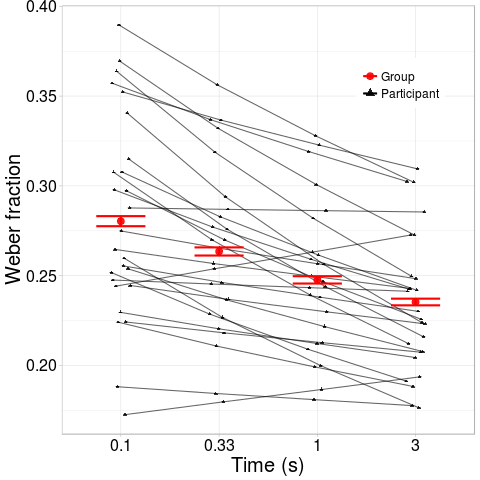

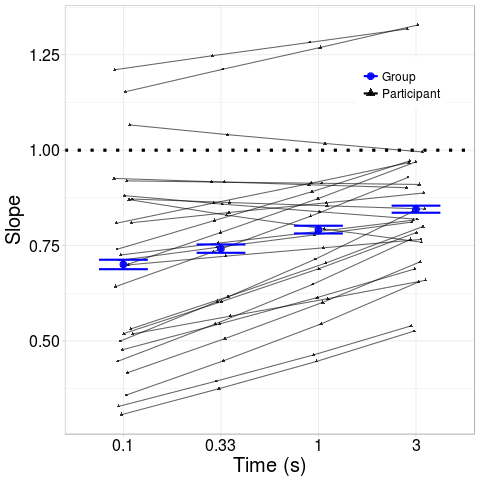

In [12]:
%%R -i sum_vals summary

sum_vals <- sum_vals %>%
            mutate(t=log(Time)) %>%
           # mutate(t=Time) %>%
            mutate(real_weber=exp(weber + time_weber*t)) %>%
            mutate(real_slope=exp(slope+ time_slope * t)) %>%
            mutate(real_weber_high=exp(weber - time_weber_high * t)) %>%
            mutate(real_weber_low=exp(weber - time_weber_low * t)) %>%
            mutate(real_slope_high=exp(slope+time_slope_high*t)) %>%
            mutate(real_slope_low=exp(slope+time_slope_low*t)) %>%

            #mutate(real_weber_=exp(weber + time_weber*Time))# %>%
            mutate(guess=real_slope*Dots_Shown) %>%
            mutate(noise=real_weber*Dots_Shown)


sum_vals$id <- seq.int(1,nrow(sum_vals))
mean_reg_vals <- sum_vals %>%
                group_by(pid, Time) %>%
               top_n(n=1, wt=id)




p.1 <- ggplot(data=sum_vals, aes(x=as.character(Time), y=real_weber)) +
       stat_summary(fun.y="mean", geom="line", size=0.5, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant"), alpha=0.6) +
       stat_summary(fun.y="mean", geom="point", size=1,alpha=0.8, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +

       stat_summary(fun.data="mean_se", geom="errorbar", size=0.25, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +

        stat_summary(geom="errorbar", width=0.5,size=1.0, fun.data="mean_se", aes(color="Group")) +
      stat_summary(geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Red", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            legend.position=c(0.82,0.82),
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16,color="black"),
                            axis.text.y=element_text(size=16,color="black"),
                            axis.title.x=element_text(face="plain", size=20),
                            axis.title.y=element_text(face="plain", size=20)) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Weber fraction") + xlab("Time (s)")         
                        
    

p.2 <- ggplot(data=sum_vals, aes(x=as.character(Time), y=1.25*real_slope-0.2 )) +
       stat_summary(fun.y="mean", geom="line", size=0.5, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant"), alpha=0.6) +
       stat_summary(fun.y="mean", geom="point",alpha=0.8, size=1.0, position=position_dodge(width=0.2),
                    aes(group=pid, color="Participant", shape="Participant")) +


        stat_summary(geom="errorbar", width=0.5,size=1.0, fun.data="mean_se", aes(color="Group")) +
      stat_summary(geom="point", fun.y="mean", size=3., alpha=0.9, aes(color="Group", shape="Group")) +
    #stat_summary(fun.y="mean", geom="line", size=4) +
        scale_color_manual(name="a", values=c("Blue", "Black"),labels=c("Group", "Participant")) +
        scale_shape_manual(name="a", values=c(19, 17), labels=c("Group", "Participant")) +
        #geom_errorbar(aes(ymin=real_weber - real_weber_sd, ymax=real_weber+real_weber_sd)) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            legend.position=c(0.82,0.82),
                            axis.text.x=element_text(size=16,color="black"),
                            axis.text.y=element_text(size=16,color="black"),

                         axis.title.x=element_text(face="plain", size=20),
                            axis.title.y=element_text(face="plain", size=20)) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +
            geom_hline(linetype="dotted", yintercept=1, size=1.5) +

            ylab("Slope") + xlab("Time (s)")  
                        
#ggsave("figs/time_weber.png", width=5,height=4,dpi=300)


p.3 <- ggplot(data=mean_reg_vals, aes(x=as.character(Time), y=(guess - Dots_Shown)/Dots_Shown)) +
           # geom_point() +
            stat_summary(fun.data="mean_se") +
            #geom_errorbar(aes(ymin=real_slope_high, ymax=real_slope_low)) +
            #facet_wrap(~pid) +
      paper_theme_2 + theme(legend.text=element_text(size=12), 
                            strip.text=element_blank(), 
                            axis.text.x=element_text(size=16,color="black"),
                         axis.title.x=element_text(face="plain", size=20),
                            axis.title.y=element_text(face="plain", size=20)) +
        theme(legend.text=element_text(size=12), legend.title=element_blank()) +

            ylab("Slope") + xlab("Time (s)") 

p.4 <- ggplot(data=sum_vals, aes(x=Dots_Shown, 
                                 y=(Dots_Counted-Dots_Shown)/Dots_Shown, 
                                 color=factor(Time), group=Time)) +
        stat_smooth(method="loess", span=1.5, se=FALSE) +
        stat_smooth(method="loess", span=1.5, se=TRUE, alpha=0.1)


p.4 <- ggplot(data=sum_vals, aes(x=Dots_Shown, 
                                 y=Dots_Counted/Dots_Shown, 
                                 color=factor(Time), group=Time)) +
        stat_smooth(method="loess", span=1.5, se=FALSE) +
        stat_smooth(method="loess", span=1.5, se=TRUE, alpha=0.1)

print(p.1)
ggsave("figs/time_weber.png", width=5,height=4, dpi=300)
ggsave("figs/time_weber.pdf", width=5,height=4, dpi=300)

print(p.2)
ggsave("figs/time_slope.png", width=5,height=4, dpi=300)
ggsave("figs/time_slope.pdf", width=5,height=4, dpi=300)

#print(p.4)
#print(mean_reg_vals)
print(mean(mean_reg_vals$real_weber))
print(mean(mean_reg_vals$real_weber_high))
print(mean(mean_reg_vals$real_weber_low))

#print(summary(mean_reg_vals$real_slope))

#print(mean(mean_reg_vals$time_slope))
#print(median(mean_reg_vals$time_weber))
#print(median(mean_reg_vals$time_slope))


#print(summary(lm(data=mean_reg_vals, real_slope ~ factor(Time)-1)))
#print(summary(lm(data=mean_reg_vals, real_weber ~ factor(Time)-1)))

#print(summary(lm(data=mean_reg_vals, (time_slope*Time) ~ factor(Time)-1)))

#print(p.3)
